In [1]:
import torch.nn.functional as F
import torch
import torchvision
from matplotlib import pyplot as plt
import os

In [2]:
root_dir = './'
torchvision.datasets.MNIST(root=root_dir,download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [3]:
# Load MNIST dataset
train_set = torchvision.datasets.MNIST(root=root_dir, download=True, train=True)
test_set = torchvision.datasets.MNIST(root=root_dir, download=True, train=False)

In [4]:
# Dataset len
num_train = len(train_set)
num_test = len(test_set)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

Num. training samples: 60000
Num. test samples:     10000


In [5]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [26]:
# extract data and targets
x_train, y_train=train_set.data,train_set.targets
print(x_train.shape)
print(y_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [190]:
#FATTA DA ME 08 07 22
import random
nr_ex = 12000
x_train_bin = x_train>0
x_train_bin = x_train_bin.double()

nr_act_pixels = torch.zeros(x_train_bin.size()[0])
for ex in range(x_train_bin.size()[0]):
  nr_act_pixels[ex]=(torch.sum(x_train_bin[ex,:,:])/784)
  
mask = torch.rand(nr_ex ,28, 28)  # uniformly distributed between 0 and 1

for it in range(nr_ex):
  up_or_low = random.randint(0, 3)
  if up_or_low==0:
    up_b = torch.distributions.uniform.Uniform(0,torch.min(nr_act_pixels)).sample()
    mask[it,:,:] = mask[it,:,:] < up_b   # up_b% pixels "on"
  elif up_or_low==1:
    low_b = torch.distributions.uniform.Uniform(torch.max(nr_act_pixels),1).sample()
    mask[it,:,:] = mask[it,:,:] > low_b   # up_b% pixels "on"
  elif up_or_low==2:
    #low_b = torch.min(nr_act_pixels)
    up_b = torch.max(nr_act_pixels)
    mask[it,:,:] = mask[it,:,:] < up_b
  else:
    mask[it,:,:] = mask[it,:,:] <1

mask = torch.unsqueeze(mask,1)
mask_int = F.interpolate(mask, size=(32, 32), mode='bicubic', align_corners=False)

i = random.randint(0,12000)
print(i)
plt.imshow( mask_int[i,0,:,:] , cmap = 'gray')

In [206]:
# add a dimension to tensor to become B*C*H*W
if len(x_train.shape)==3:
  x_train=x_train.unsqueeze(1)
print(x_train.shape)

torch.Size([60000, 1, 28, 28])


In [207]:
def show(img):
  # convert tensor to numpy array
  npimg = img.numpy()
  # Convert to H*W*C shape
  npimg_tr=np.transpose(npimg, (1,2,0))
  plt.imshow(npimg_tr,interpolation='nearest')

torch.Size([3, 152, 242])


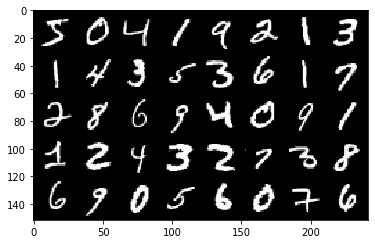

In [208]:
# make a grid of 40 images, 8 images per row
x_grid=utils.make_grid(x_train[:40], nrow=8, padding=2)
print(x_grid.shape)
# call helper function
show(x_grid)

In [209]:
# List of indexes on the training set
train_idx = list(range(num_train))

# List of indexes of the test set
test_idx = list(range(num_test))

In [210]:
# Shuffle the training set
import random

random.shuffle(train_idx)
for i in range(10):
  print(train_idx[i])

36137
16789
34521
44336
31888
47435
41556
2459
29030
11148


In [211]:
# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train * val_frac) 
num_train = num_train - num_val

# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")

48600 samples used as train set
5400  samples used as val set


In [212]:
len(train_idx)

48600

In [218]:
from torchvision import transforms

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
])
# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

In [220]:
#FATTA DA ME 08 07 22
imgs = torch.zeros(54000,1,32,32)
lbls = torch.zeros(54000)
c=0
for i in train_idx:
  image, label = train_set[i]
  imgs[c,:,:,:]= image
  lbls[c] = label
  c = c+1

ds = torch.cat((imgs, mask_int), 0)

Nan_lbls = torch.ones(12000)*10
ds_lbls = torch.cat((lbls, Nan_lbls), 0)



Label: 0


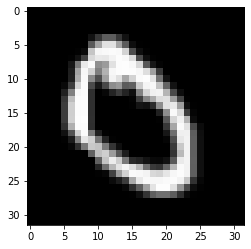

In [221]:
image, label = train_set[1]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

In [223]:
# Split train_dataset into training and validation
from torch.utils.data import Subset

val_set = Subset(train_set, val_idx)
train_set = Subset(train_set, train_idx)

In [226]:
# Define loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=64, num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=64, num_workers=2, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_set,  batch_size=64, num_workers=2, shuffle=False, drop_last=False)


In [227]:
#fatta da me 08 07. train set con i fake data
_dataset = torch.utils.data.TensorDataset(ds,ds_lbls) # create your datset
train_loader = torch.utils.data.DataLoader(_dataset,batch_size=64, num_workers=2, shuffle=True, drop_last = True) # create your dataloader

In [228]:
import torch.nn as nn

In [229]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels,batch_norm=False):

        super().__init__()

        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1
                        }

        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        #self.bn1 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        #self.bn2 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

In [230]:
class VGG16(nn.Module):

  def __init__(self, input_size, num_classes=10,batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)


  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)

    return x

In [231]:
# Create the model
model = VGG16((1,32,32),batch_norm=True)
print(model)

VGG16(
  (block_1): VGGBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): VGGBlock(
    (conv1): Conv2d(128,

In [232]:
# Get an element from the dataset
test_x, _ = train_set[0] # each element of the dataset is a couple (image, label)

In [233]:
# Get the size of a sample
test_x.size()

torch.Size([1, 32, 32])

In [234]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 1, 32, 32])

In [235]:
output=model(test_x)
output.shape

torch.Size([1, 512, 2, 2])

In [236]:
class VGG16(nn.Module):

  def __init__(self, input_size, num_classes=11,batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)

    self.classifier = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1) 
        )

  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)

    return x

In [237]:
# Create the model
model = VGG16((1,32,32), batch_norm=True)
output = model(test_x)
output.shape

torch.Size([1, 11])

In [238]:
torch.cuda.is_available()

True

In [239]:
dev = torch.device('cuda')
print(dev)

cuda


In [240]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

In [241]:
def train(net, loaders, optimizer, criterion, epochs=20, dev=dev, save_param = False, model_name="VGG16_MNIST"):
    try:
        net = net.to(dev)
        #print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    #pred = pred.squeeze(dim=1) # Output shape is [Batch size, 1], but we want [Batch size]
                    #labels = labels.unsqueeze(1)
                    labels = labels.long()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    #pred_labels = pred.argmax(1) + 1
                    #pred_labels = (pred >= 0.5).long() # Binarize predictions to 0 and 1
                    _,pred_label = torch.max(pred, dim = 1)
                    pred_labels = (pred_label == labels).float()

                    batch_accuracy = pred_labels.sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              #torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
              from google.colab import drive
              drive.mount('/content/gdrive')

              save_path = "/content/gdrive/My Drive/VGG16_MNIST"

              try:
                  os.mkdir(save_path)
              except:
                  print("Folder already found")
              filename = save_path + '/'+ f"{model_name}_best_val.pth"
     
              torch.save(net.state_dict(), filename)
              best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [242]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

In [ ]:
# Train model
train(model, loaders, optimizer, criterion, epochs=20, dev=dev, save_param = True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder already found
Epoch 1: TrL=2.0653, TrA=0.4724, VL=1.8631, VA=0.6972, TeL=1.8599, TeA=0.7024,
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder already found
Epoch 2: TrL=1.6850, TrA=0.8775, VL=1.6808, VA=0.8686, TeL=1.6754, TeA=0.8725,
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder already found
Epoch 3: TrL=1.6401, TrA=0.9075, VL=1.6605, VA=0.8841, TeL=1.6561, TeA=0.8876,
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder already found
Epoch 4: TrL=1.6292, TrA=0.9170, VL=1.6034, VA=0.9518, TeL=1.5950, TeA=0.9592,
Drive already mounted at /content/gdrive; to attempt to forcibly remount, ca

tensor([[6.5808e-06, 9.6557e-01, 4.4878e-04, 1.1819e-05, 2.8777e-06, 2.0329e-04,
         2.3727e-08, 3.3752e-02, 1.2506e-08, 1.4447e-07, 7.9037e-06]],
       device='cuda:0') tensor([1], device='cuda:0') tensor([0.1537], device='cuda:0')


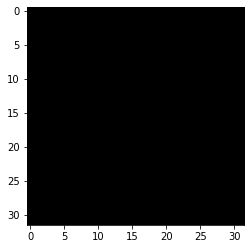

In [170]:
#test che funzia 08 07 22
bl = torch.zeros(1,1,32,32)
plt.imshow( bl[0,0,:,:] , cmap = 'gray')

with torch.no_grad():
  pred_vals=model(bl.to(dev))

_, inds = torch.max(pred_vals,dim=1)
e = torch.distributions.Categorical(probs =pred_vals).entropy()
print(pred_vals,inds,e)